In [1]:
import warnings
warnings.filterwarnings("ignore")
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
#plt.style.use("ggplot")
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler



### Time series data can be categorized in various ways based on its characteristics. Here are some common types of time series data:

 #### 1)Univariate vs. Multivariate:
a) Univariate Time Series: Contains single observations recorded sequentially over equal time increments.

b) Multivariate Time Series: Contains multiple observations (variables) recorded sequentially over equal time increments.

 #### 2) Continuous vs. Discrete:
a) Continuous Time Series: Data points are recorded at every moment in a given range.

b) Discrete Time Series: Data points are recorded at specific intervals.

 #### 3) Stationary vs. Non-stationary:
a) Stationary Time Series: Statistical properties (like mean and variance) remain constant over time.

b) Non-stationary Time Series: Statistical properties change over time.

 #### 4)Seasonal vs. Non-seasonal:
a) Seasonal Time Series: Patterns repeat at regular intervals.

b) Non-seasonal Time Series: No repeating patterns or trends.

 #### 5) Cyclical vs. Non-cyclical:
a) Cyclical Time Series: Patterns occur at irregular intervals, typically driven by business/economic cycles.

b) Non-cyclical Time Series: No cyclical patterns.

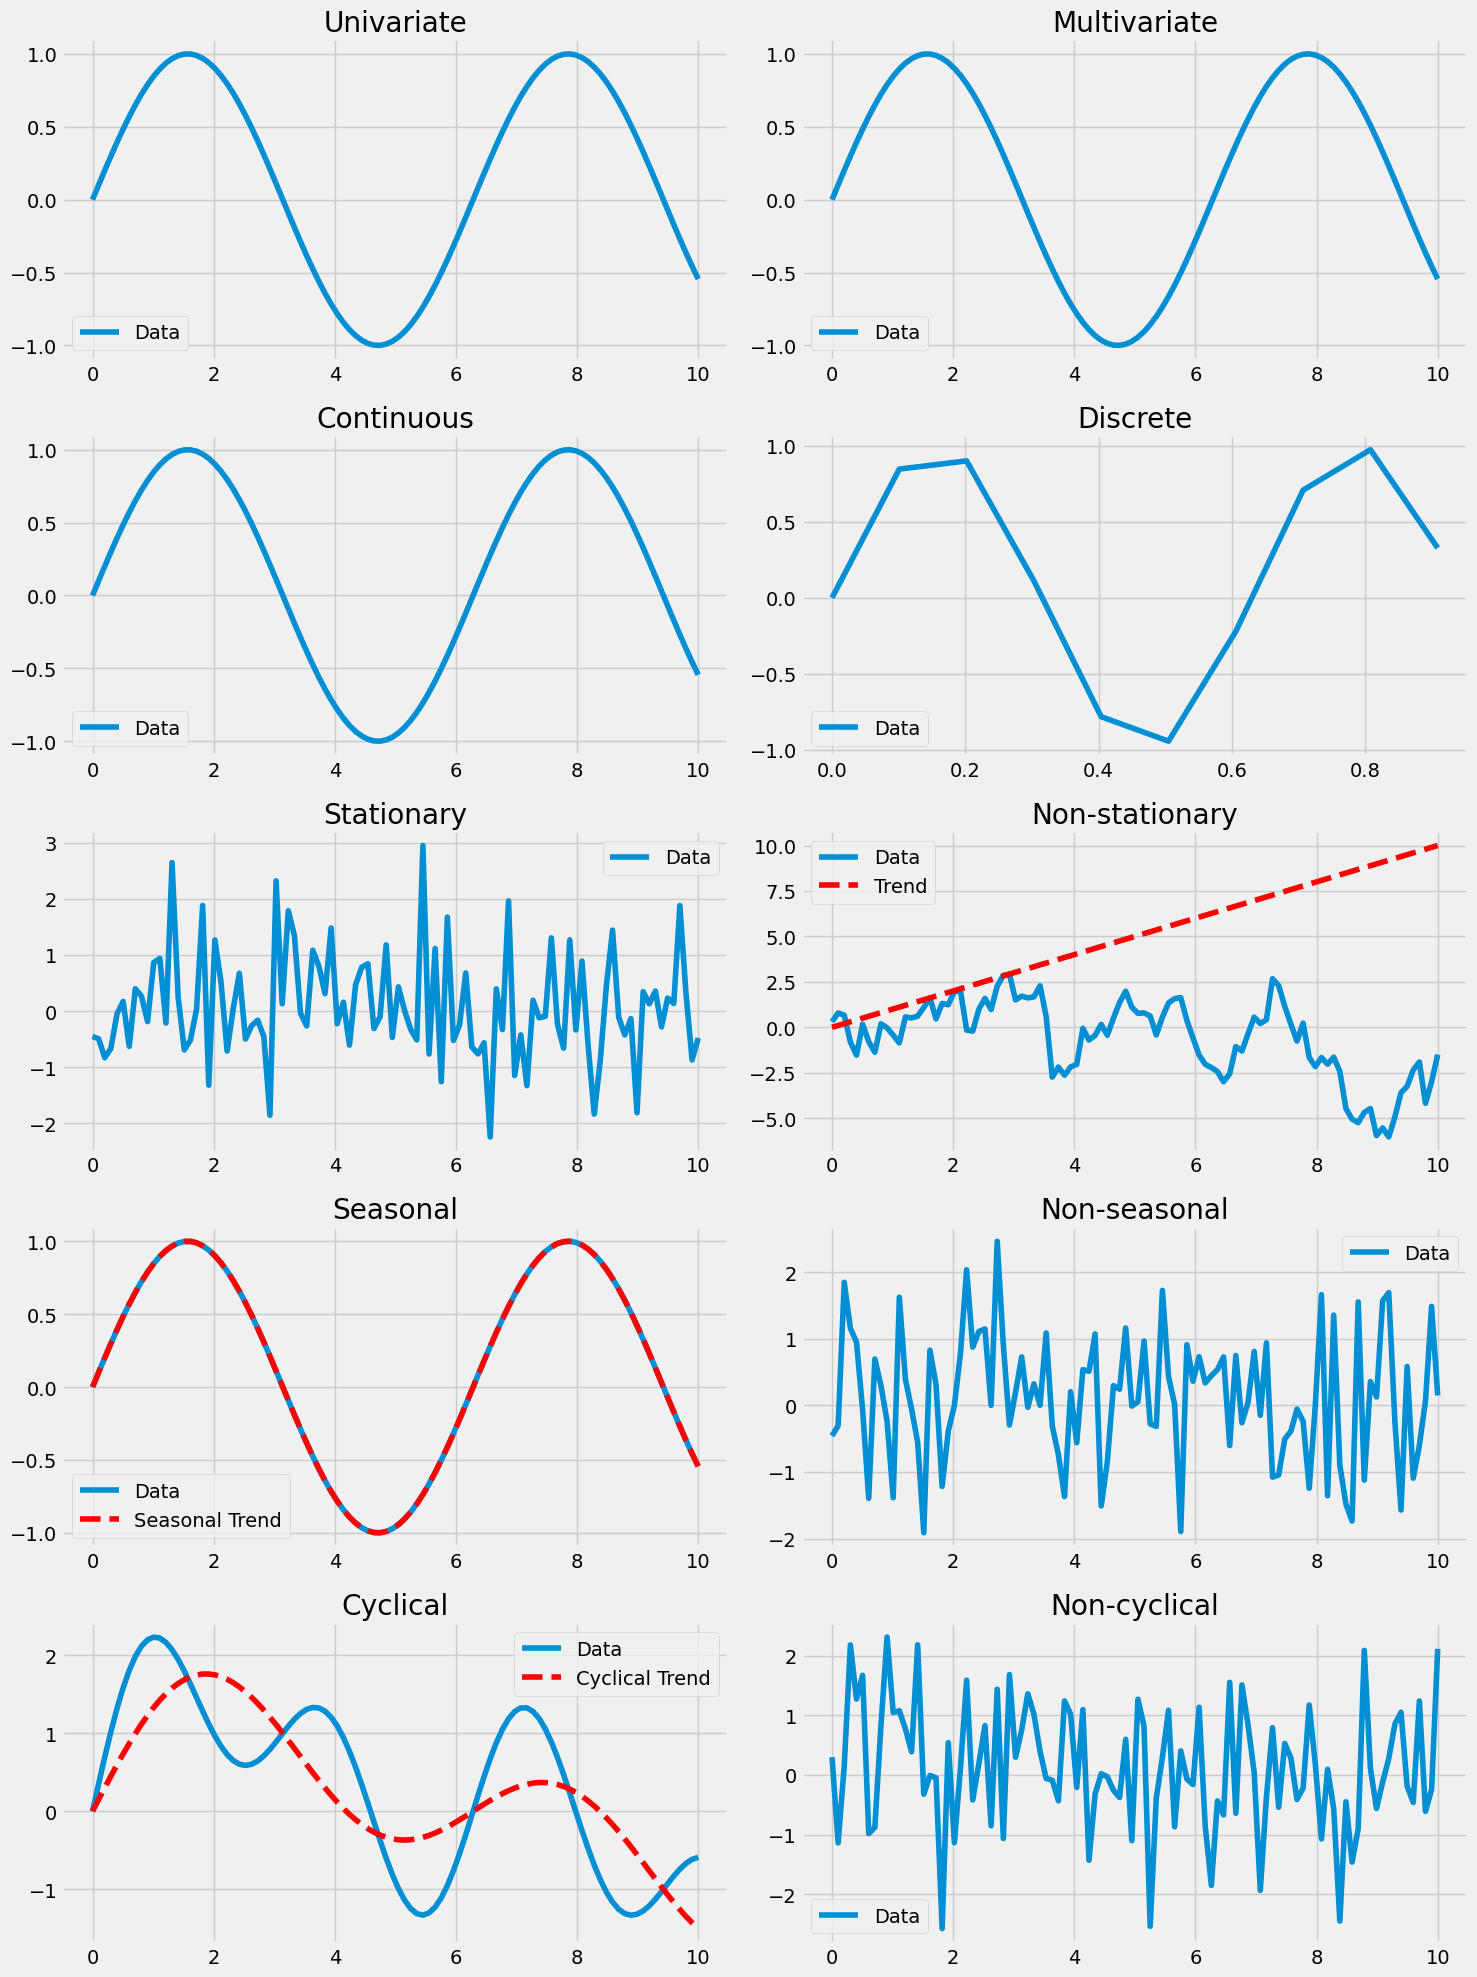

In [2]:
# Sample data generation
t = np.linspace(0, 10, 100)

# Univariate and Multivariate
univariate = np.sin(t)
multivariate = np.column_stack((np.sin(t), np.cos(t)))

# Continuous and Discrete
continuous = np.sin(t)
discrete = continuous[::10]

# Stationary and Non-stationary
stationary = np.random.randn(100)
non_stationary = np.cumsum(np.random.randn(100))

# Seasonal and Non-seasonal
seasonal = np.sin(t)
non_seasonal = np.random.randn(100)

# Cyclical and Non-cyclical
cyclical = np.sin(0.5 * t) + np.sin(t) + np.sin(2 * t)
non_cyclical = np.random.randn(100)

# Visualization
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))
titles = ['Univariate', 'Multivariate', 'Continuous', 'Discrete', 'Stationary', 'Non-stationary', 'Seasonal', 'Non-seasonal', 'Cyclical', 'Non-cyclical']
data = [univariate, multivariate[:, 0], continuous, discrete, stationary, non_stationary, seasonal, non_seasonal, cyclical, non_cyclical]

for ax, title, d in zip(axes.ravel(), titles, data):
    ax.plot(t[:len(d)], d, label='Data')
    
    # Adding trend lines where appropriate
    if title == "Non-stationary":
        ax.plot(t[:len(d)], np.linspace(0, 10, len(d)), 'r--', label='Trend')
    if title == "Seasonal":
        ax.plot(t[:len(d)], np.sin(t[:len(d)]), 'r--', label='Seasonal Trend')
    if title == "Cyclical":
        ax.plot(t[:len(d)], np.sin(t[:len(d)]) + np.sin(0.5 * t[:len(d)]), 'r--', label='Cyclical Trend')
    
    ax.set_title(title)
    ax.legend()

plt.tight_layout()
plt.show()


In [3]:
data_path = '/kaggle/input/hourly-energy-consumption/PJME_hourly.csv'
df = pd.read_csv(data_path)
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [4]:
df.shape

(145366, 1)

In [5]:
print('start:', df.index[0])
print('end:', df.index[-1])
print('days: ', (df.index[-1]-df.index[0]).days)

start: 2002-12-31 01:00:00
end: 2018-01-02 00:00:00
days:  5480


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PJME_MW,145366.0,32080.222831,6464.012166,14544.0,27573.0,31421.0,35650.0,62009.0


## Datetime:
The dataset spans from December 31, 2002, to Jenuary 3, 2018, with a total of 145,366 hourly records.

## PJME_MW:

This represents the power consumption in megawatts. The average consumption is around 32,080 MW, with a standard deviation of about 6,465 MW. The minimum observed consumption is 14,544 MW, and the maximum is 62,009 MW.
This dataset is a comprehensive collection of hourly power consumption data over multiple years, suitable for time-series analysis and forecasting. Would you like to proceed with any specific analysis or steps using this dataset


## Basic data inspection:

In [7]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [8]:
df.tail()

,PJME_MW
Datetime,
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0
2018-01-02 00:00:00,38608.0


In [9]:
df.info

<bound method DataFrame.info of                      PJME_MW
Datetime                    
2002-12-31 01:00:00  26498.0
2002-12-31 02:00:00  25147.0
2002-12-31 03:00:00  24574.0
2002-12-31 04:00:00  24393.0
2002-12-31 05:00:00  24860.0
...                      ...
2018-01-01 20:00:00  44284.0
2018-01-01 21:00:00  43751.0
2018-01-01 22:00:00  42402.0
2018-01-01 23:00:00  40164.0
2018-01-02 00:00:00  38608.0

[145366 rows x 1 columns]>

In [10]:
df.isnull().sum()  # No missing values inthe Dataset

PJME_MW    0
dtype: int64

##  Plotting the data

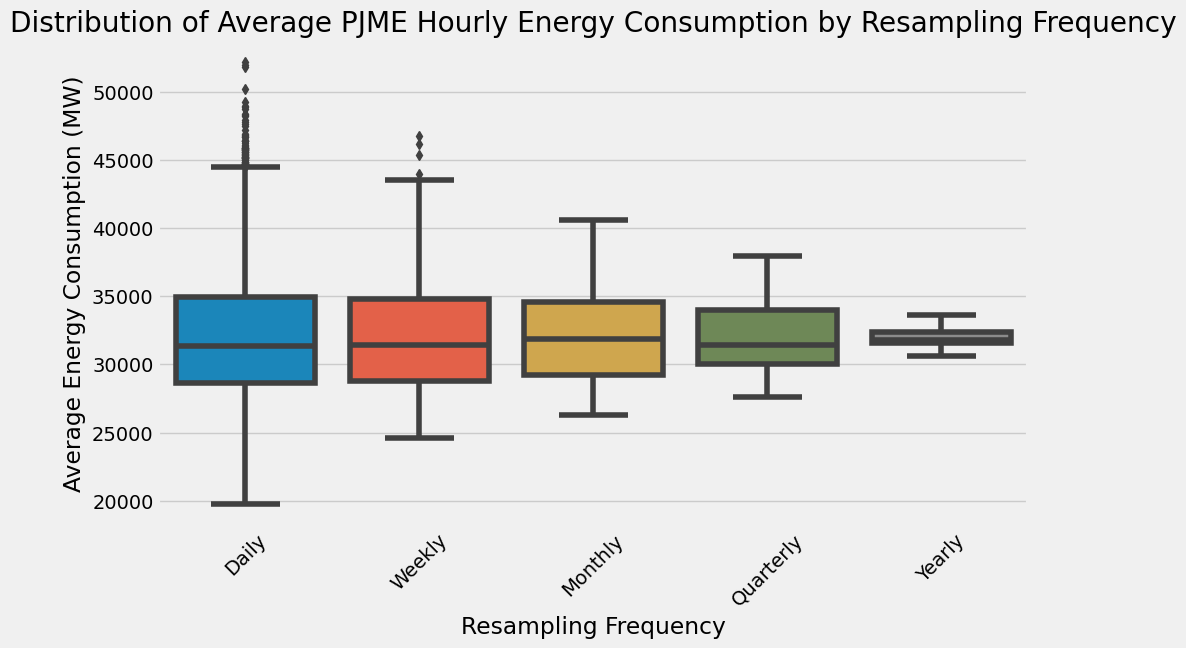

In [11]:
# Defining the resampling frequencies
frequencies = ['D', 'W', 'M', 'Q', 'A']

# Initialize a list to hold the resampled data in a long format
data_long_format = []

# Looping through each frequency to resample data and store it in long format
for freq in frequencies:
    resampled_data = df['PJME_MW'].resample(freq).mean().reset_index()
    resampled_data['Frequency'] = freq  # Add a column indicating the frequency
    data_long_format.append(resampled_data)

# Concatenate all the resampled data into a single DataFrame
data_long_df = pd.concat(data_long_format)

# Mapping the frequency codes to full names for better plot readability
frequency_labels = {
    'D': 'Daily', 
    'W': 'Weekly', 
    'M': 'Monthly', 
    'Q': 'Quarterly', 
    'A': 'Yearly'
}
data_long_df['Frequency'] = data_long_df['Frequency'].map(frequency_labels)

# Creating the box plot with Seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_long_df, x='Frequency', y='PJME_MW')
plt.title('Distribution of Average PJME Hourly Energy Consumption by Resampling Frequency')
plt.ylabel('Average Energy Consumption (MW)')
plt.xlabel('Resampling Frequency')
plt.xticks(rotation=45)
plt.show()


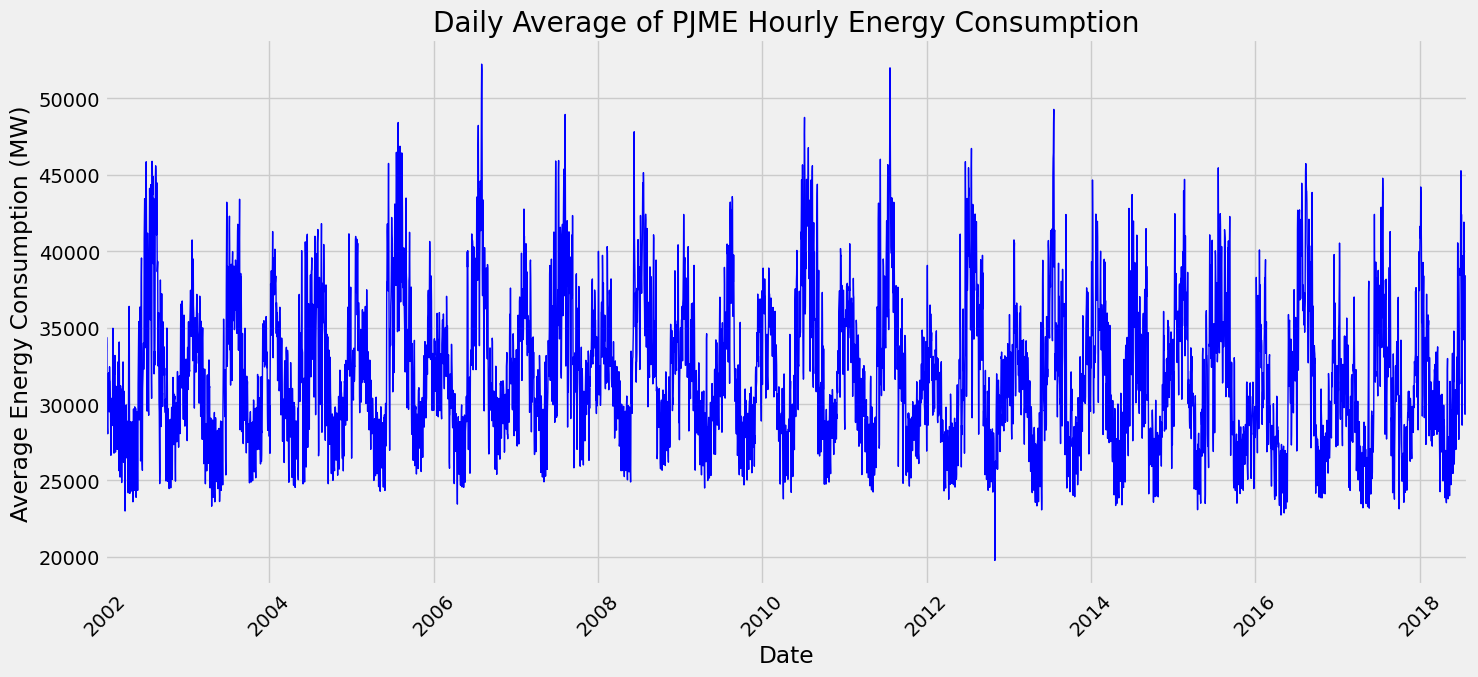

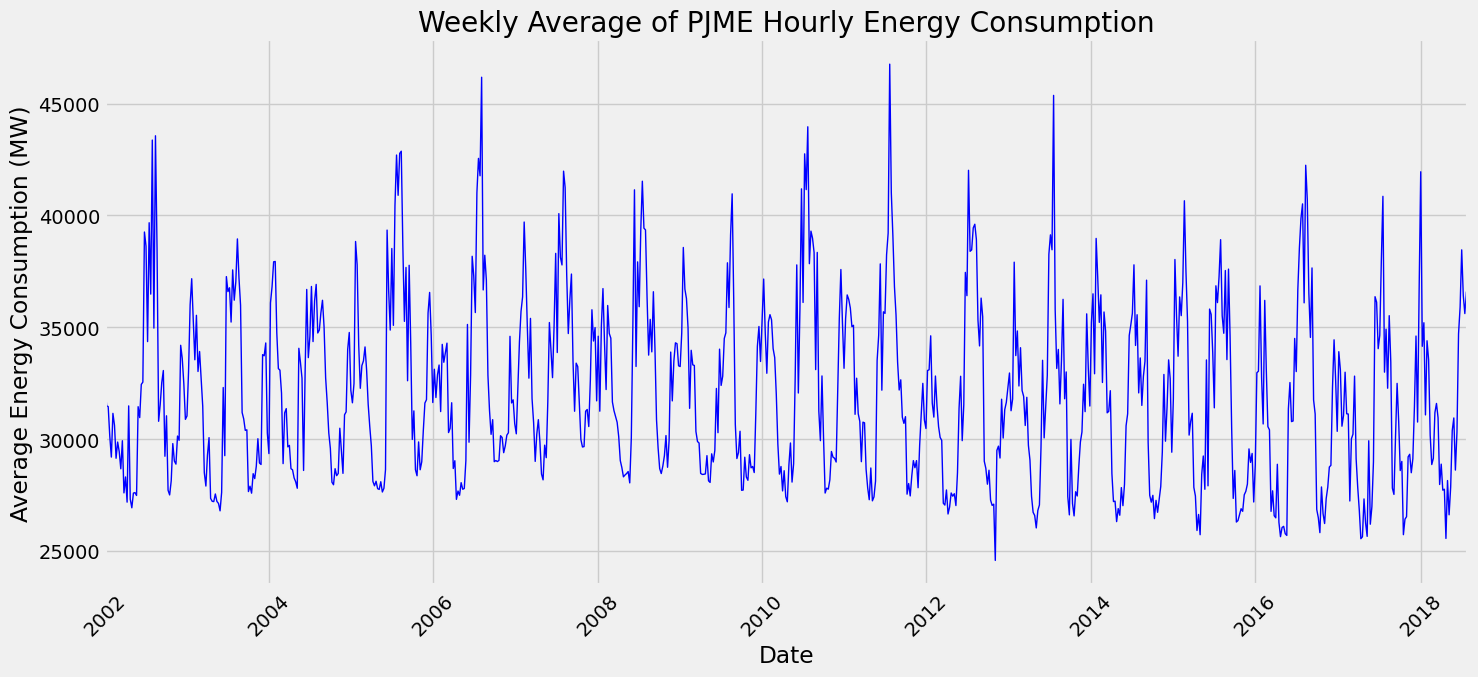

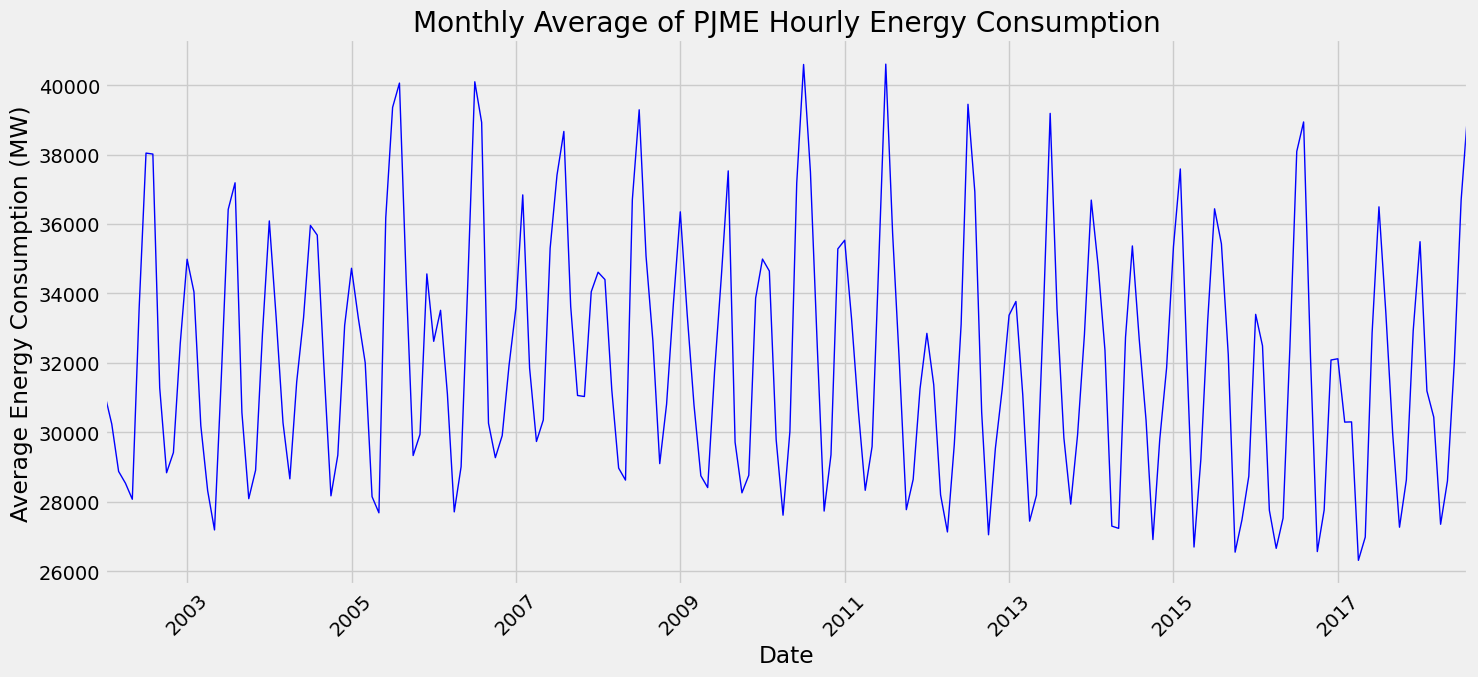

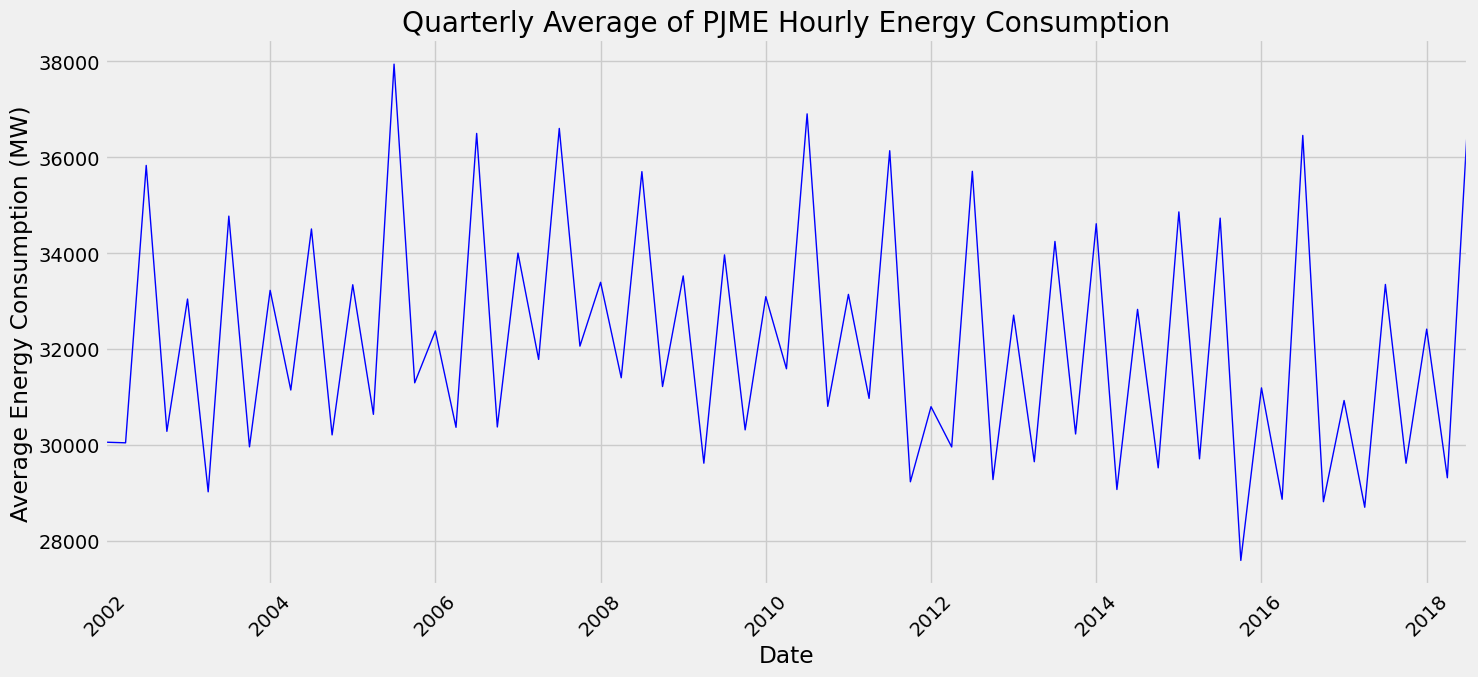

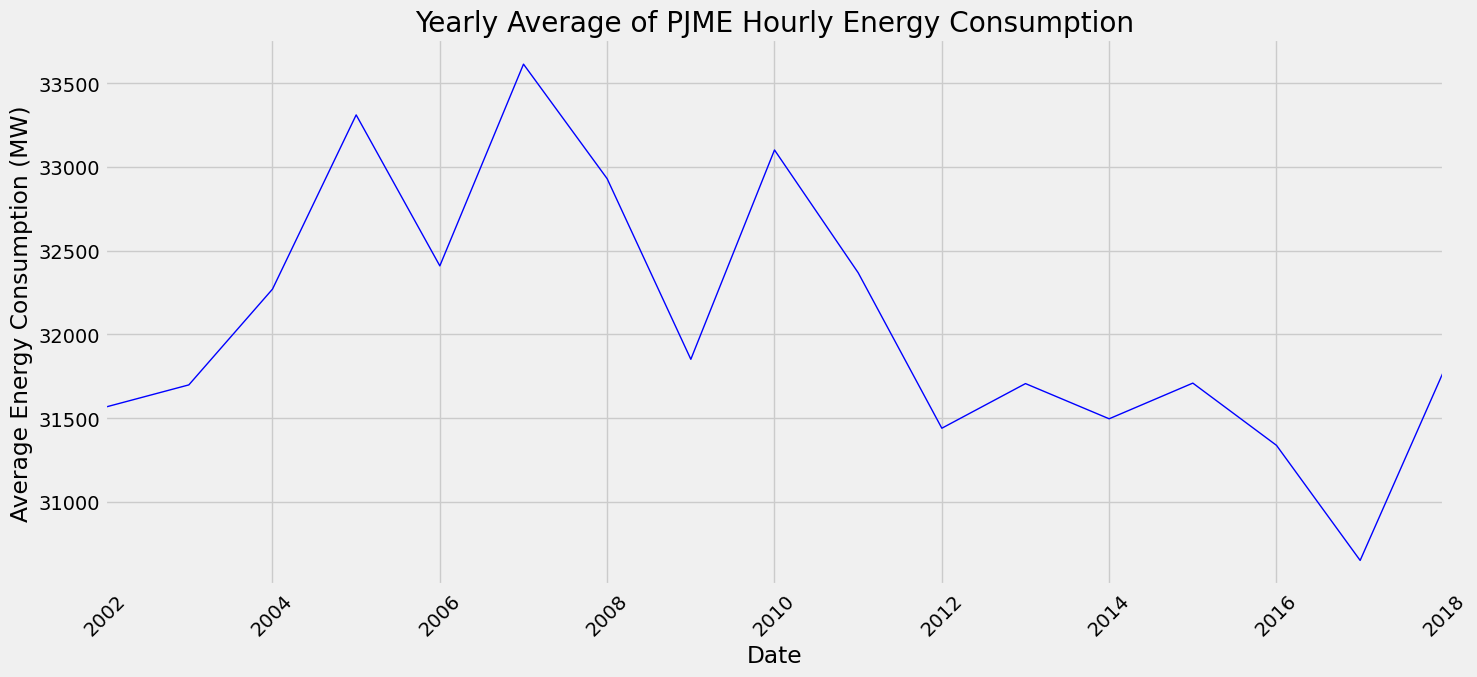

In [12]:
# Defining the resampling frequencies and their corresponding titles
frequencies = [ 'D',  'W', 'M', 'Q', 'A']
titles = [ 'Daily', 'Weekly', 'Monthly', 'Quarterly', 'Yearly']

# Looping through each frequency and create a plot
for freq, title in zip(frequencies, titles):
    # Resampling the data
    resampled_data = df.resample(freq).mean()
    
    # Plotting the resampled data
    plt.figure(figsize=(15, 7))
    resampled_data['PJME_MW'].plot(color='blue', linewidth=1)
    plt.title(f'{title} Average of PJME Hourly Energy Consumption')  
    plt.xlabel('Date')
    plt.ylabel('Average Energy Consumption (MW)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Plotting a shorter range for clarity

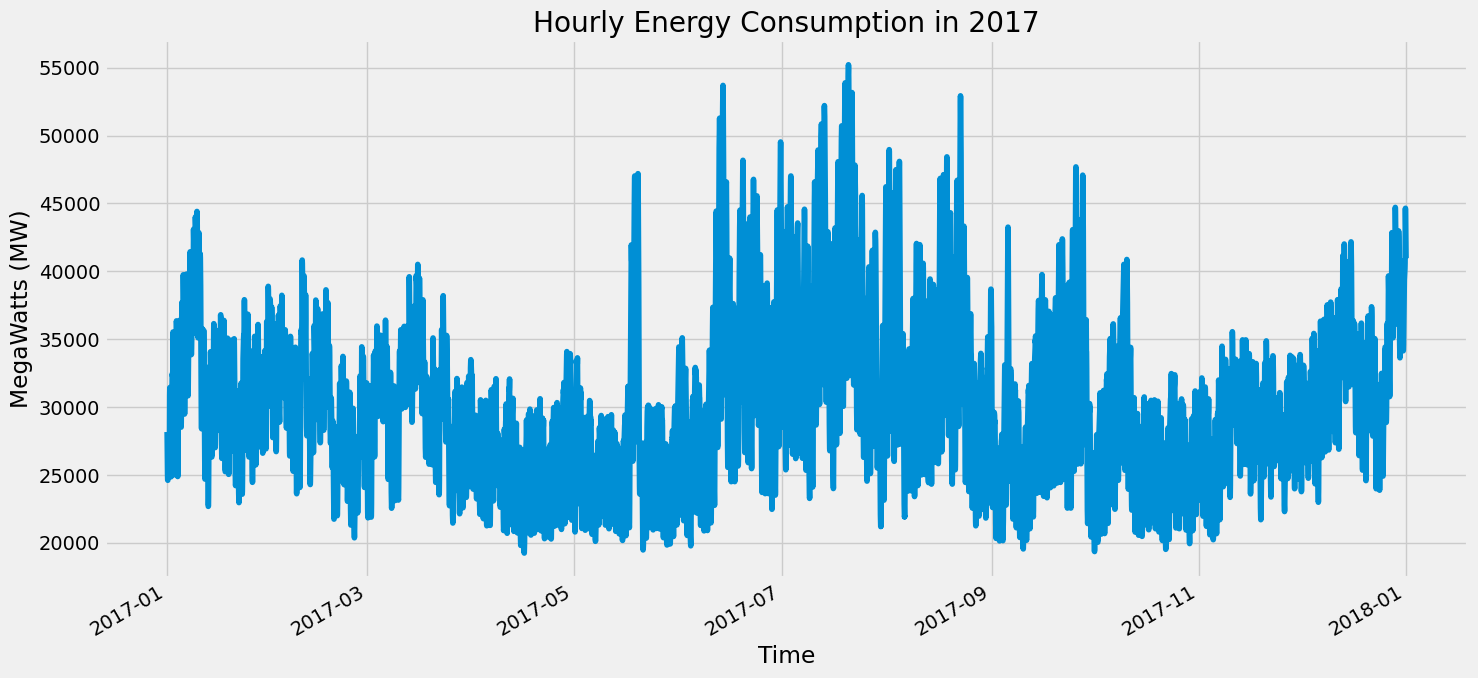

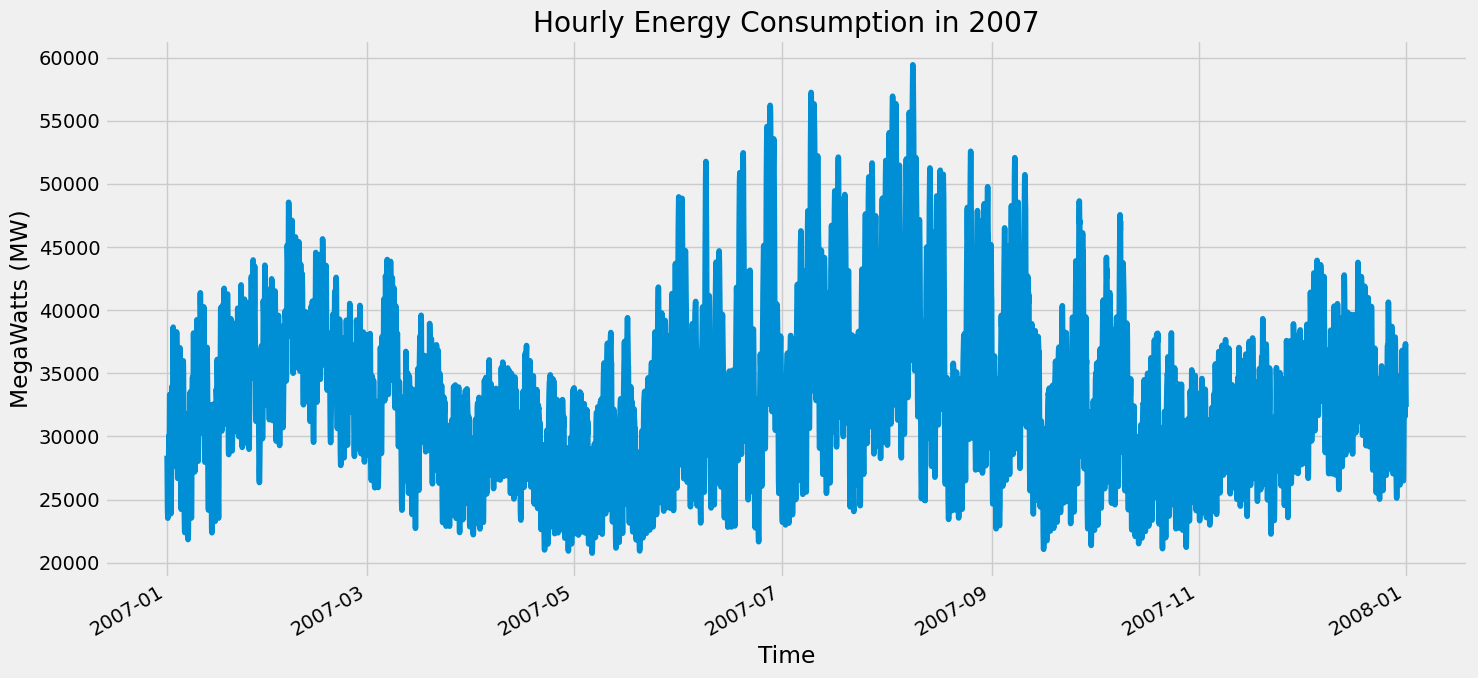

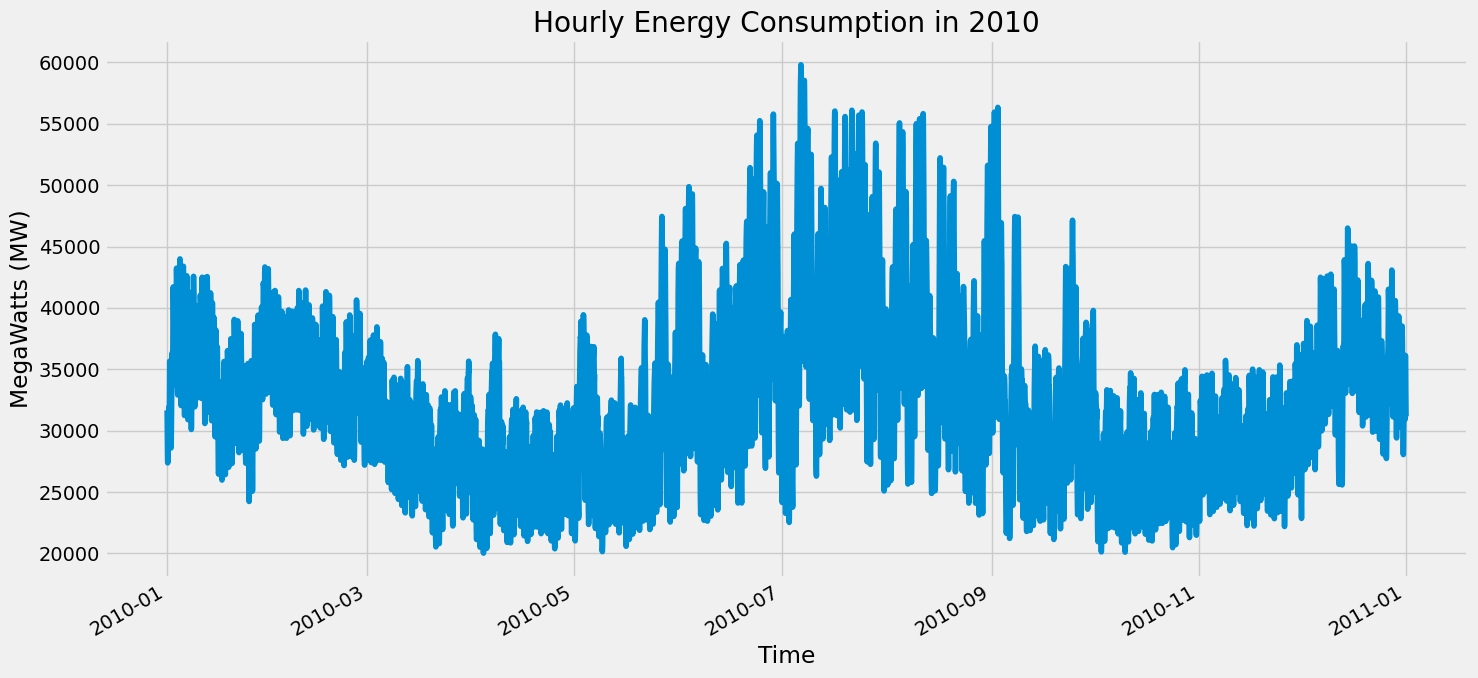

In [20]:
years = ['2017', '2007', '2010']

for year in years:
    plt.figure(figsize=(15,7))
    start_date = f'{year}-01-01'
    end_date = f'{year}-12-31'
    df['PJME_MW'][start_date:end_date].plot(title=f'Hourly Energy Consumption in {year}')
    plt.ylabel('MegaWatts (MW)')
    plt.xlabel('Time')
    plt.tight_layout()
    plt.show()


### Testing for Stationarity

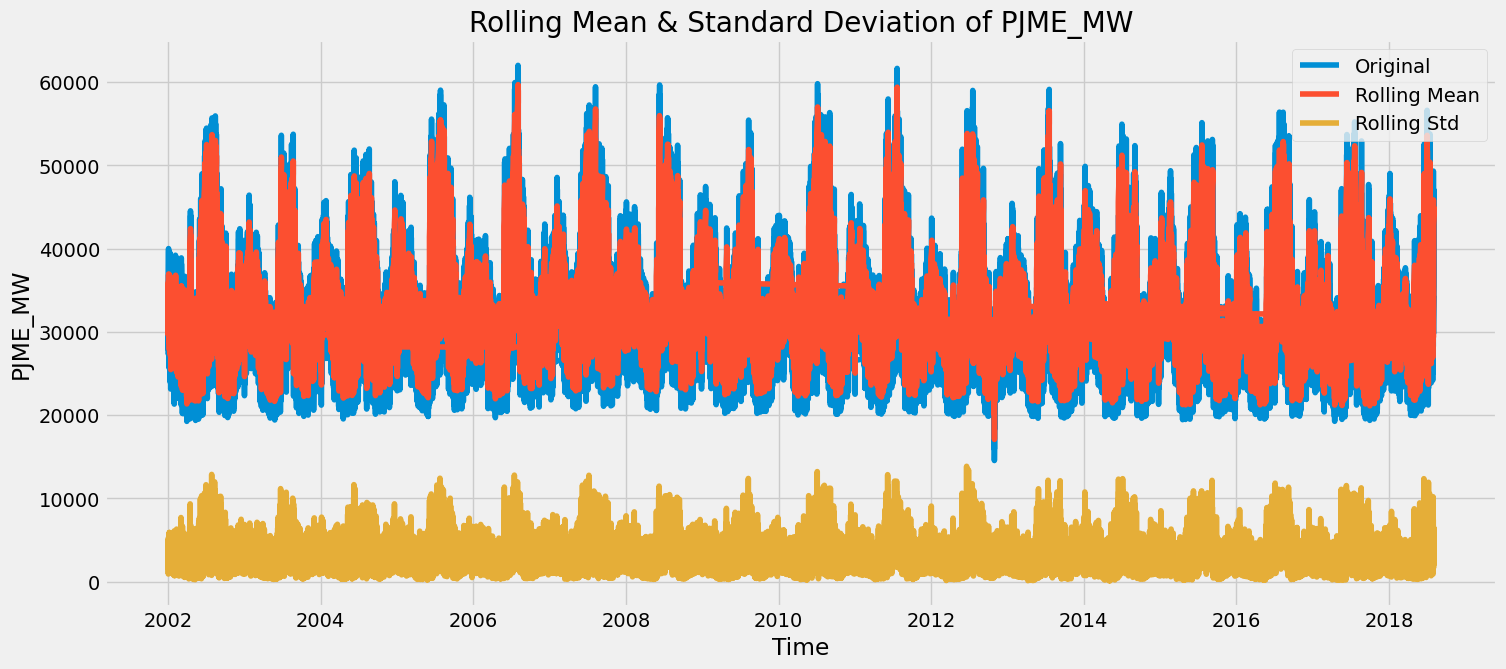

In [21]:
# Calculating the rolling mean and standard deviation for 'PJME_MW'
rolling_mean = df['PJME_MW'].rolling(window=12).mean()
rolling_std = df['PJME_MW'].rolling(window=12).std()

# Define the data to plot
data_to_plot = {
    'Original': df['PJME_MW'],
    'Rolling Mean': rolling_mean,
    'Rolling Std': rolling_std
}

# Creating the plot
fig, ax = plt.subplots(figsize=(16, 7))
for label, data in data_to_plot.items():
    ax.plot(data, label=label)

ax.set_title('Rolling Mean & Standard Deviation of PJME_MW')
ax.legend(loc='best')
plt.xlabel('Time')  
plt.ylabel('PJME_MW')
plt.show()


In [22]:
test_result = adfuller(df['PJME_MW'])
test_result

(-18.828912729084117,
 2.022124508152674e-30,
 74,
 145291,
 {'1%': -3.430395009088914,
  '5%': -2.861559893380481,
  '10%': -2.5667805885384065},
 2296512.8411437003)

In [15]:
# Function to perform Augmented Dickey-Fuller test with interpretation
def Dickey_Fuller_test(series):
    result = adfuller(series)
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    output = pd.Series(result[0:4], index=labels)

    for key, value in result[4].items():
        output[f'Critical Value ({key})'] = value

    # Interpretation based on p-value
    if result[1] <= 0.05:
        print("Evidence strongly suggests the time series is stationary. The null hypothesis (presence of a unit root) is rejected.")
        print(f"ADF Test Statistic: {result[0]}")
        print(f"p-value: {result[1]}")
        print(f"Number of Lags Used: {result[2]}")
        print(f"Number of Observations: {result[3]}")
        for key, value in result[4].items():
            print(f"Critical Value ({key}): {value}")
        print("Conclusion: The data is stationary, lacking a unit root.")
    else:
        print("Evidence is insufficient to conclude the time series is stationary. The null hypothesis cannot be rejected.")
        print(f"Conclusion: The data may be non-stationary.")

    return output
adf_test_result = Dickey_Fuller_test(df['PJME_MW'])  

print(adf_test_result)


Evidence strongly suggests the time series is stationary. The null hypothesis (presence of a unit root) is rejected.
ADF Test Statistic: -18.828912729084117
p-value: 2.022124508152674e-30
Number of Lags Used: 74
Number of Observations: 145291
Critical Value (1%): -3.430395009088914
Critical Value (5%): -2.861559893380481
Critical Value (10%): -2.5667805885384065
Conclusion: The data is stationary, lacking a unit root.
ADF Test Statistic            -1.882891e+01
p-value                        2.022125e-30
#Lags Used                     7.400000e+01
Number of Observations Used    1.452910e+05
Critical Value (1%)           -3.430395e+00
Critical Value (5%)           -2.861560e+00
Critical Value (10%)          -2.566781e+00
dtype: float64


#### Feature Engineering

In [23]:
import pandas as pd

def create_time_series_features(df):
    """
    Creating time series features with respect time series index.
    """
    return df.assign(
        hour=df.index.hour,
        dayofweek=df.index.dayofweek,
        quarter=df.index.quarter,
        month=df.index.month,
        year=df.index.year,
        dayofyear=df.index.dayofyear,
        dayofmonth=df.index.day,
        weekofyear=df.index.isocalendar().week
    )

In [24]:
# Use the function to create time series features
df = create_time_series_features(df).copy()

# Display the DataFrame with the new features
df.head()


,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1


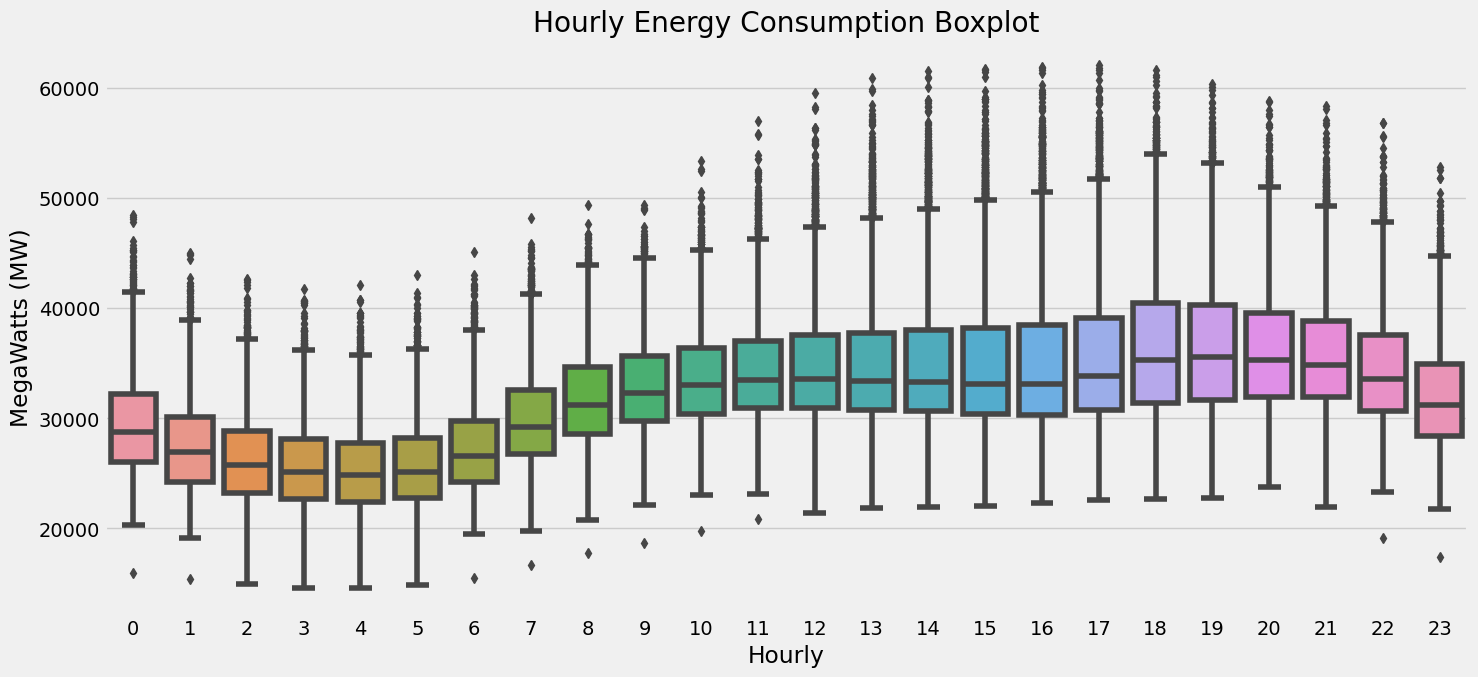

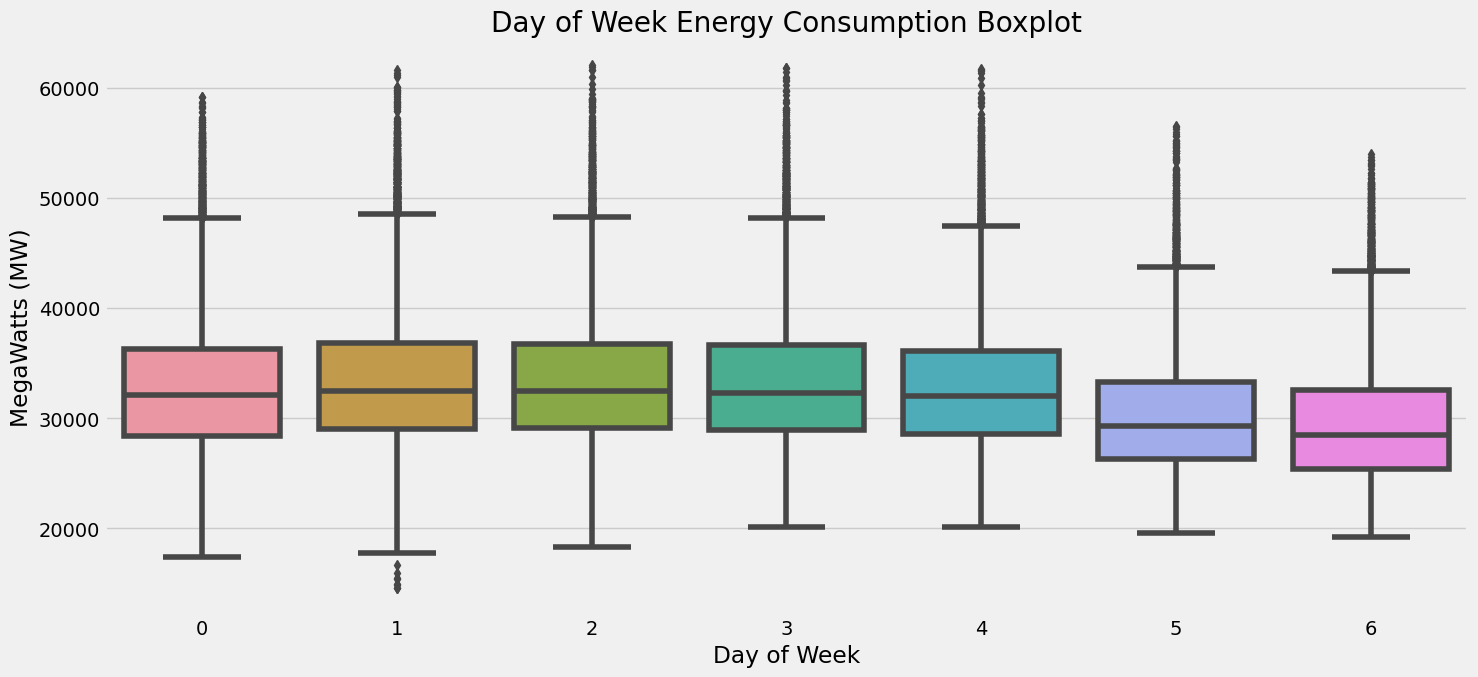

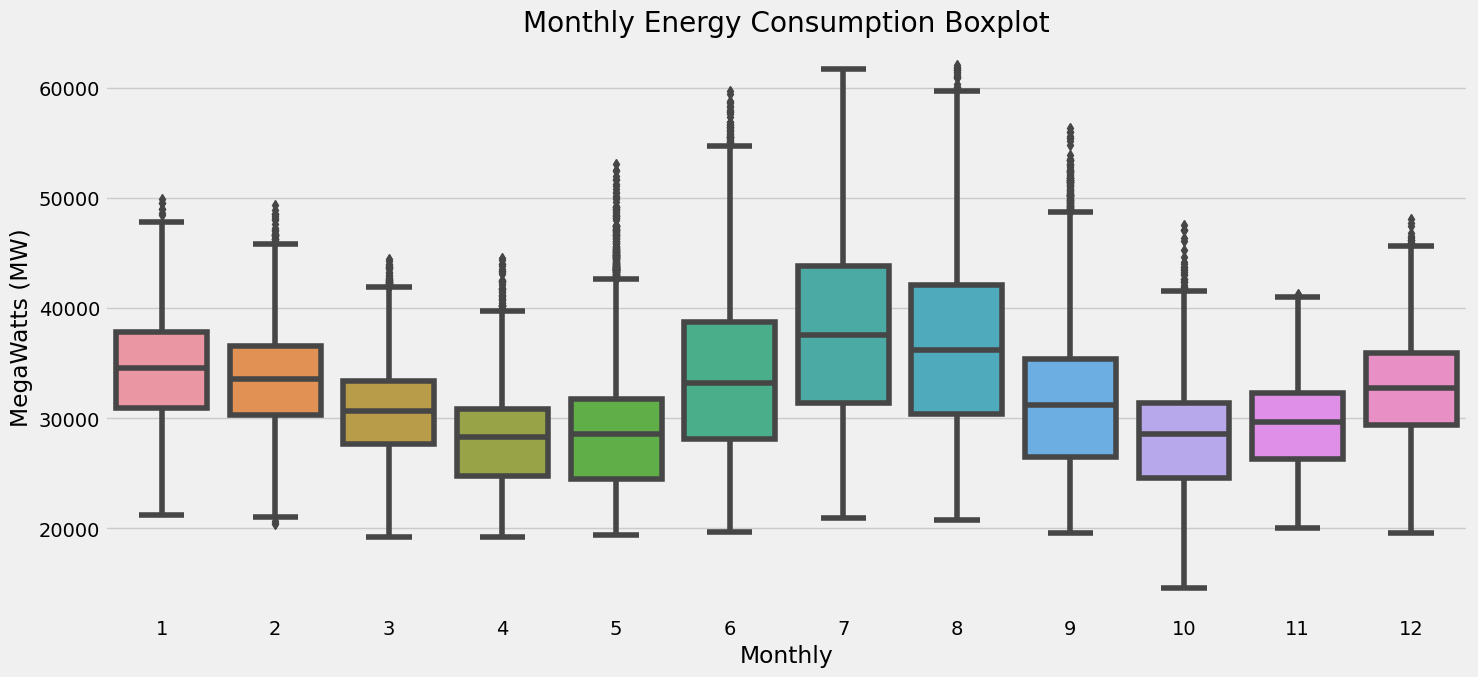

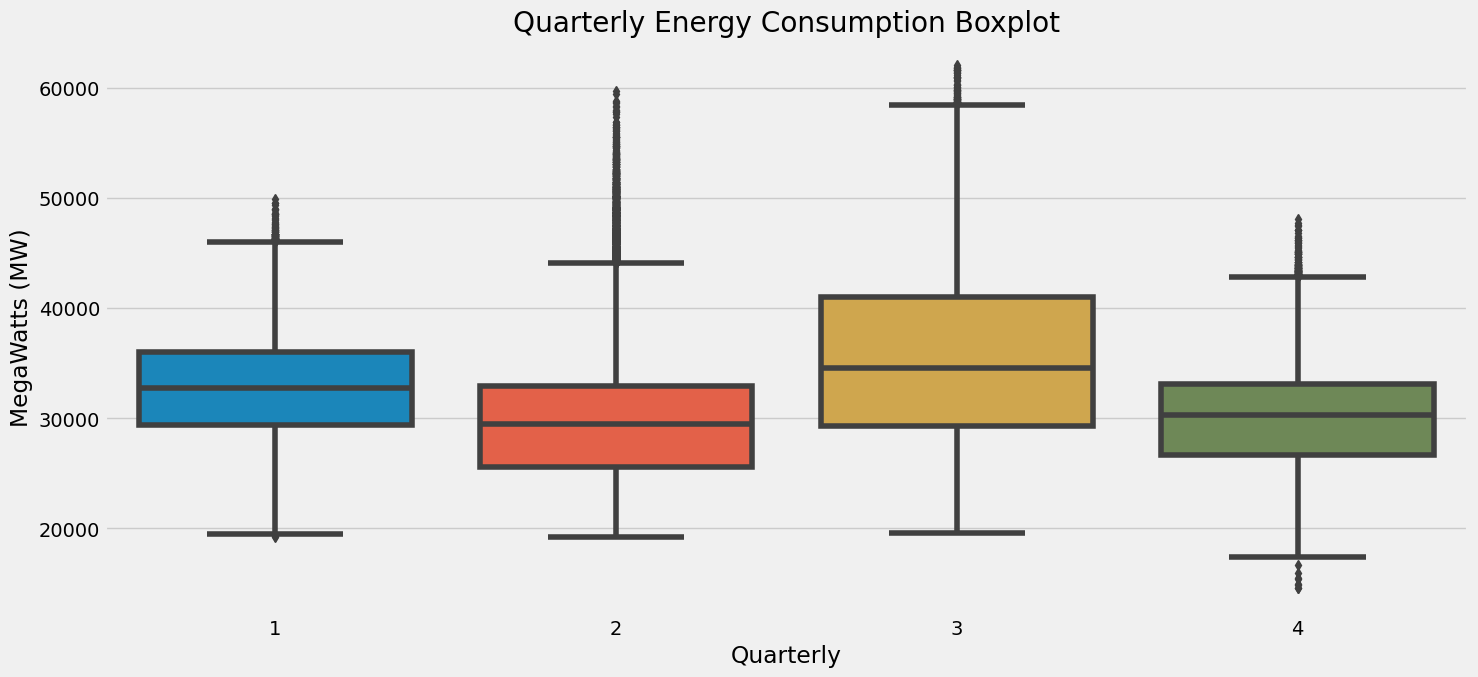

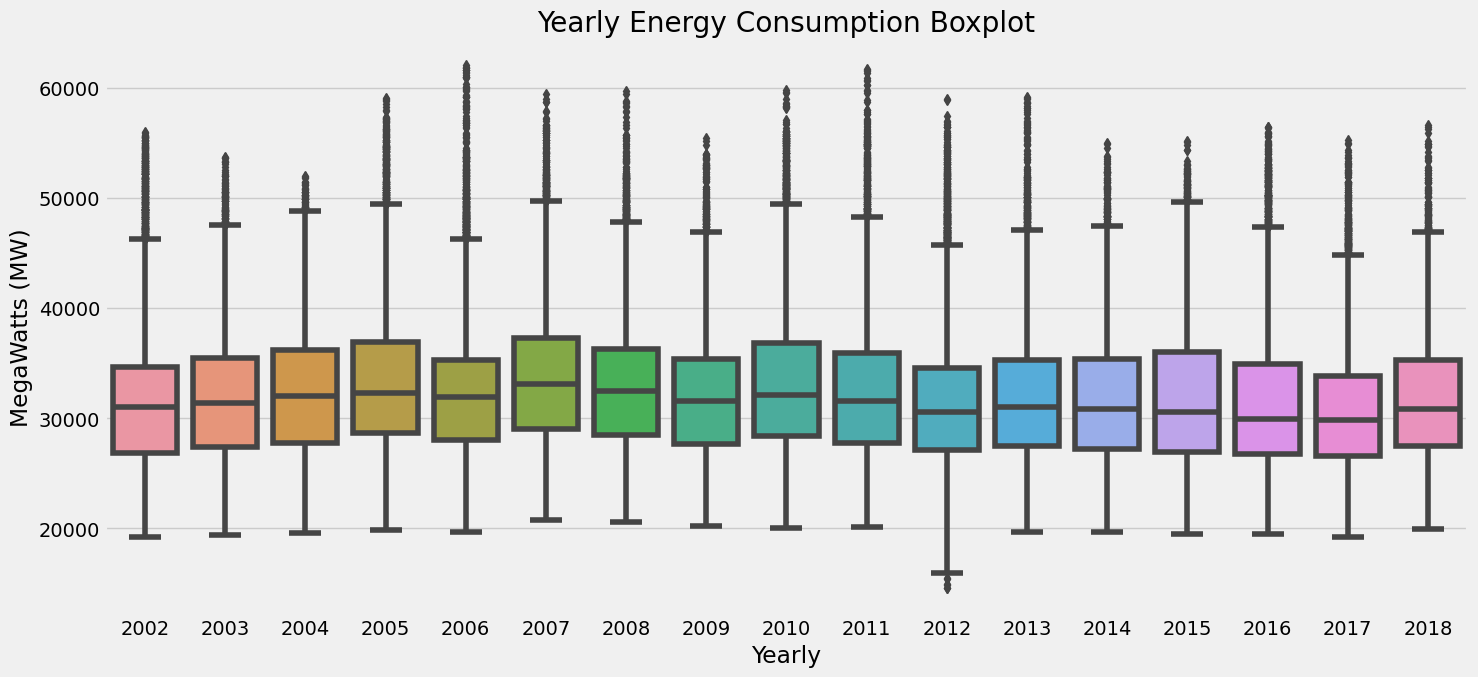

In [25]:
# Listing of time features and their corresponding labels for plotting
time_features = [
    ('hour', 'Hourly'),
    ('dayofweek', 'Day of Week'),
    ('month', 'Monthly'),
    ('quarter', 'Quarterly'),
    ('year', 'Yearly'),
    #('dayofyear', 'Day of Year'),
    #('dayofmonth', 'Day of Month'),
    #('weekofyear', 'Week of Year')
]

# Looping through each time feature and generating a boxplot using Seaborn
for feature, label in time_features:
    plt.figure(figsize=(15,7))
    sns.boxplot(data=df, x=feature, y='PJME_MW')
    plt.title(f'{label} Energy Consumption Boxplot')
    plt.ylabel('MegaWatts (MW)')
    plt.xlabel(label)
    plt.tight_layout()
    plt.show()


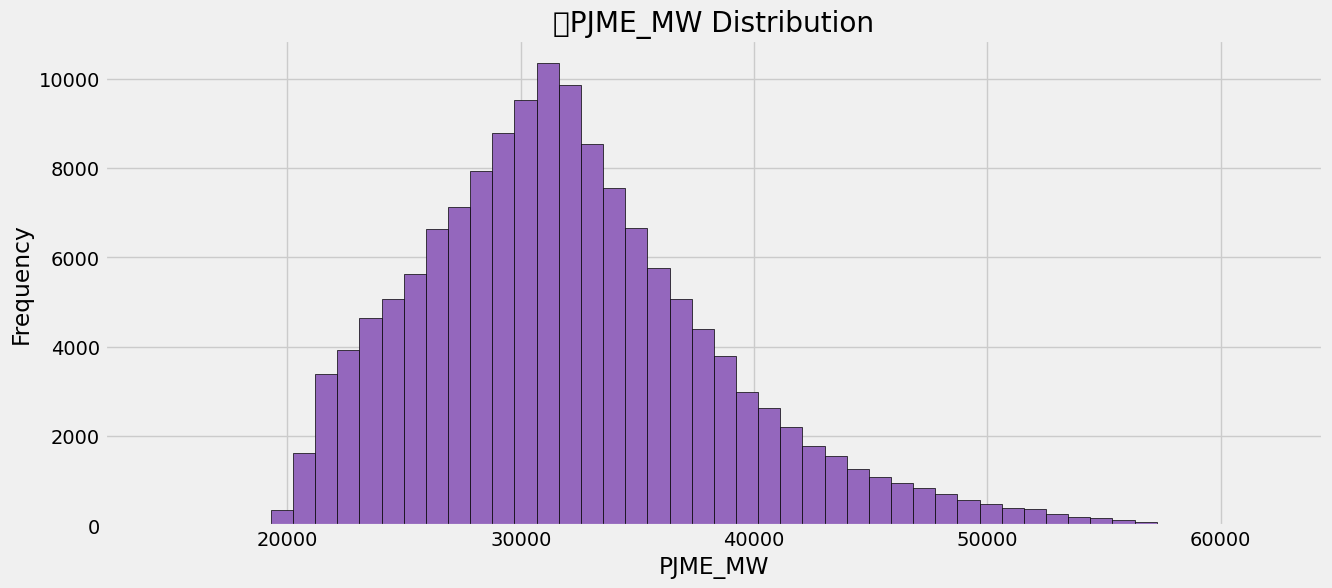

In [26]:
plt.figure(figsize=(14, 6))
plt.hist(df["PJME_MW"], bins=50,  edgecolor='black',color=color_pal[-6])

plt.title("	PJME_MW Distribution")
plt.xlabel("PJME_MW")
plt.ylabel('Frequency')
plt.show()

Text(0.5, 0, 'PJME_MW')

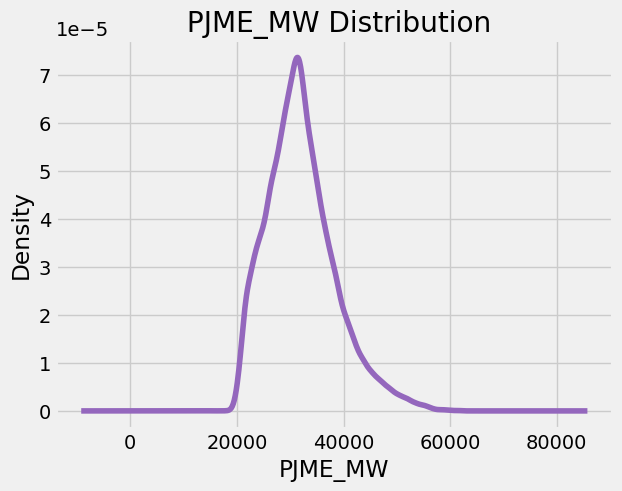

In [27]:
ax = df['PJME_MW'].plot(kind='kde', color=color_pal[-6],
                    
    title=' PJME_MW Distribution')

ax.set_xlabel('PJME_MW')

# Visualization before removing outliers

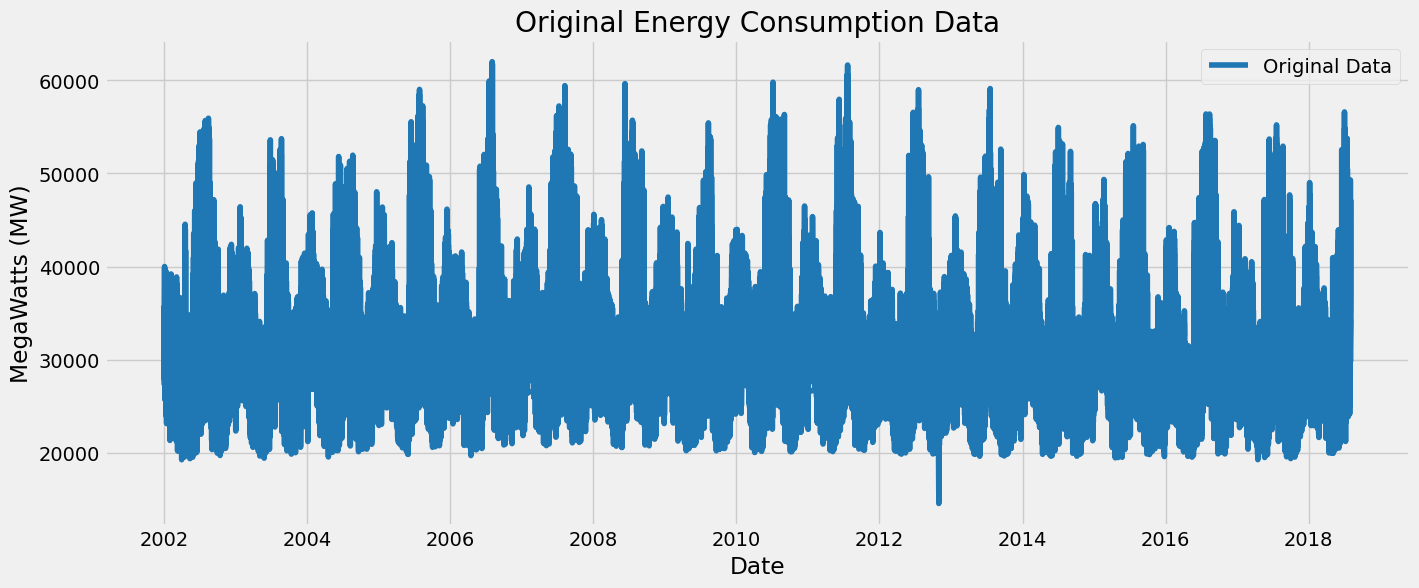

In [28]:
# 1. Visualization
plt.figure(figsize=(15, 6))
plt.plot(df['PJME_MW'], label='Original Data',  color=color_pal[0]  )
plt.title('Original Energy Consumption Data')
plt.xlabel('Date')
plt.ylabel('MegaWatts (MW)')
plt.legend()
plt.show()




##  Missing Values

In [29]:
# Display the number of missing values in each column
missing_values = df.isnull().sum()
print(missing_values)


PJME_MW       0
hour          0
dayofweek     0
quarter       0
month         0
year          0
dayofyear     0
dayofmonth    0
weekofyear    0
dtype: int64


# Outlier Detection using filters the IQR rule

In [30]:
# Filtering the rows where 'PJME_MW' is greater than 19,000
filtered_df = df.query('PJME_MW > 19_000').copy()

# Calculating Q1, Q3, and IQR for the 'PJME_MW' column of the filtered data
Q1 = filtered_df['PJME_MW'].quantile(0.25)
Q3 = filtered_df['PJME_MW'].quantile(0.75)
IQR = Q3 - Q1

# Determining the lower and upper bounds using the IQR
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identifying the outliers based on these bounds
outliers = filtered_df[(filtered_df['PJME_MW'] < lower_bound) | (filtered_df['PJME_MW'] > upper_bound)]
outliers 


,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-08-22 16:00:00,48285.0,16,3,3,8,2002,234,22,34
2002-08-22 17:00:00,48587.0,17,3,3,8,2002,234,22,34
2002-08-22 18:00:00,48302.0,18,3,3,8,2002,234,22,34
2002-08-20 14:00:00,48052.0,14,1,3,8,2002,232,20,34
2002-08-20 15:00:00,48656.0,15,1,3,8,2002,232,20,34
...,...,...,...,...,...,...,...,...,...
2018-06-18 21:00:00,48437.0,21,0,2,6,2018,169,18,25
2018-01-05 18:00:00,48945.0,18,4,1,1,2018,5,5,1
2018-01-05 19:00:00,49021.0,19,4,1,1,2018,5,5,1


In [31]:
df.shape

(145366, 9)

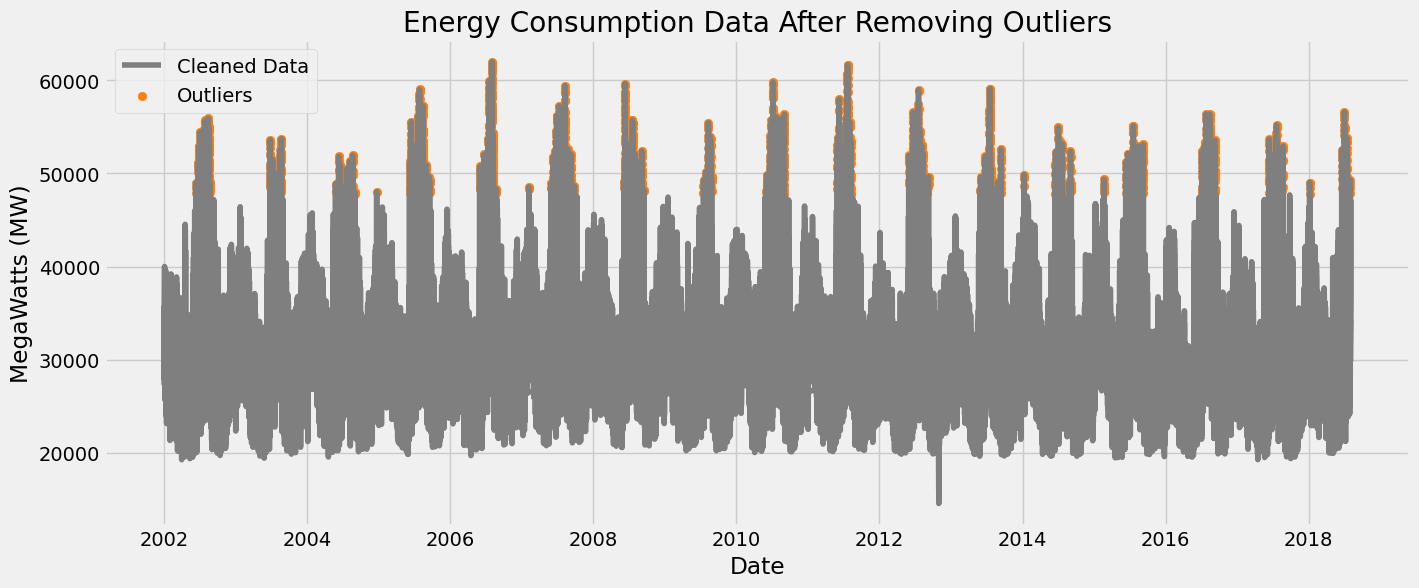

In [32]:
plt.figure(figsize=(15, 6))
plt.plot(df['PJME_MW'], label='Cleaned Data', color=color_pal[-3])
plt.scatter(outliers.index, outliers['PJME_MW'], color=color_pal[1], label='Outliers')
plt.title('Energy Consumption Data After Removing Outliers')
plt.xlabel('Date')
plt.ylabel('MegaWatts (MW)')
plt.legend()
plt.show()


# Removing Outliers

In [33]:
# Filtering the rows where 'PJME_MW' is greater than 19,000
filtered_df = df.query('PJME_MW > 19_000').copy()

# Calculating Q1, Q3, and IQR for the 'PJME_MW' column of the filtered data
Q1 = filtered_df['PJME_MW'].quantile(0.25)
Q3 = filtered_df['PJME_MW'].quantile(0.75)
IQR = Q3 - Q1

# Determing the lower and upper bounds using the IQR
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identifing the non-outliers based on these bounds
df = filtered_df[(filtered_df['PJME_MW'] >= lower_bound) & (filtered_df['PJME_MW'] <= upper_bound)].copy()
df


,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1
...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1,1,1
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1,1,1
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1,1,1


# Visualization after removing outliers

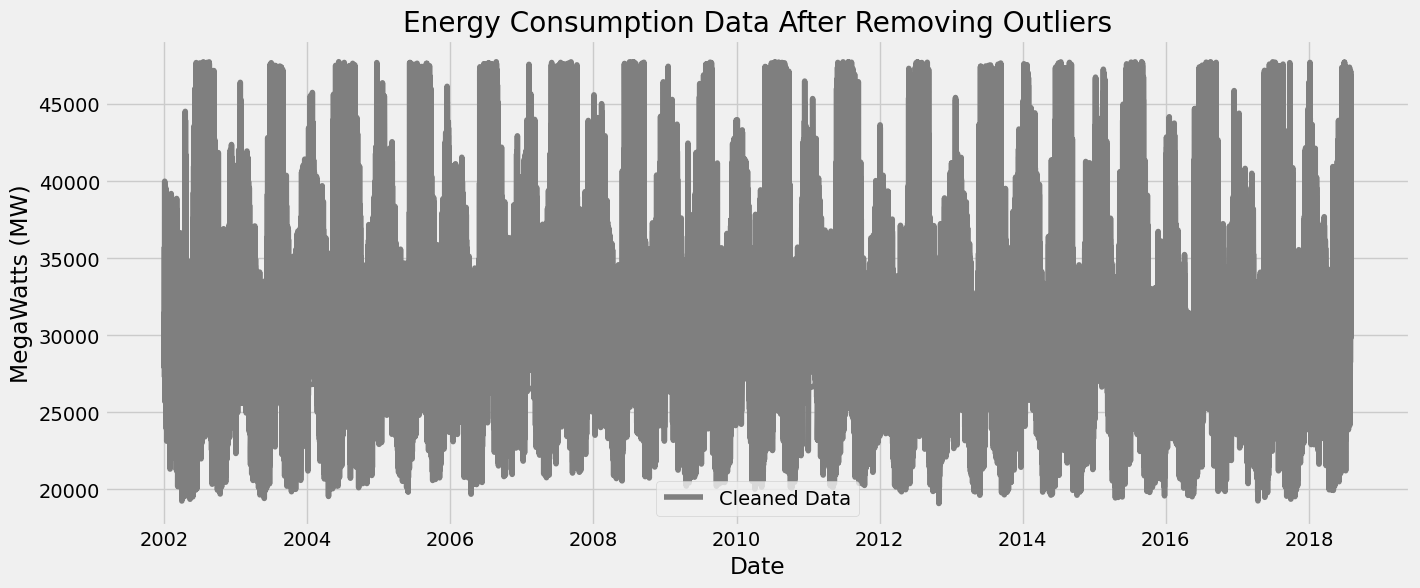

In [34]:
plt.figure(figsize=(15, 6))
plt.plot(df['PJME_MW'], label='Cleaned Data', color=color_pal[-3])
plt.title('Energy Consumption Data After Removing Outliers')
plt.xlabel('Date')
plt.ylabel('MegaWatts (MW)')
plt.legend()
plt.show()


In [35]:
df.shape

(141897, 9)

##  Determing the Split Point  and  Splitting the Dataset:

In [36]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [41]:
# Splitting the data into train and test sets
split_point = int(0.8 * len(df))
train_data = df.iloc[:split_point]
test_data = df.iloc[split_point:]
# Displaying the shapes of the train and test sets to confirm the split
print(train_data.shape, test_data.shape)  # Outputs: ((113517, 9), (28380, 9))


(113517, 9) (28380, 9)


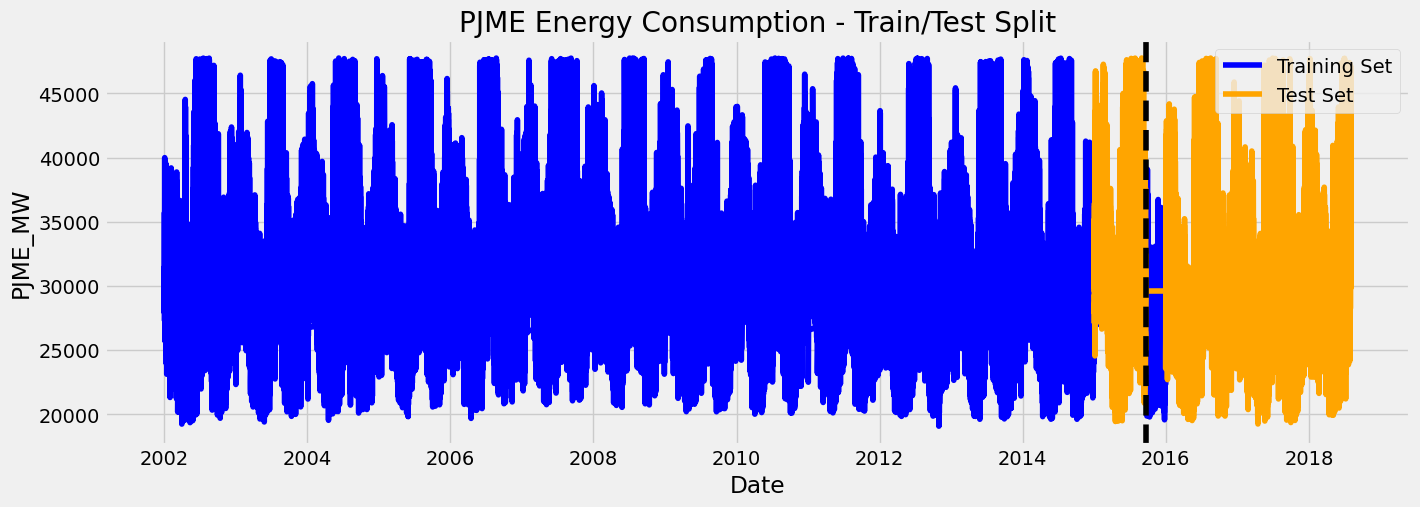

In [42]:
# Plotting
fig, ax = plt.subplots(figsize=(15, 5))

# Plotting training set
ax.plot(train_data.index, train_data['PJME_MW'], label='Training Set', color='blue')

# Plotting test set
ax.plot(test_data.index, test_data['PJME_MW'], label='Test Set', color='orange')

# Calculating split date for the vertical line
split_date = test_data.index[0]

# Adding a vertical line for the split date
ax.axvline(split_date, color='black', ls='--')

# Enhancing the plot
ax.set_title('PJME Energy Consumption - Train/Test Split')
ax.set_xlabel('Date')
ax.set_ylabel('PJME_MW')  
ax.legend()
plt.show()


In [37]:
# Splitting the data into train and test sets
split_point = int(0.8 * len(df))
train_data = df.iloc[:split_point]
test_data = df.iloc[split_point:]

# Displaying the shapes of the train and test sets to confirm the split
train_data.shape, test_data.shape


((113517, 9), (28380, 9))

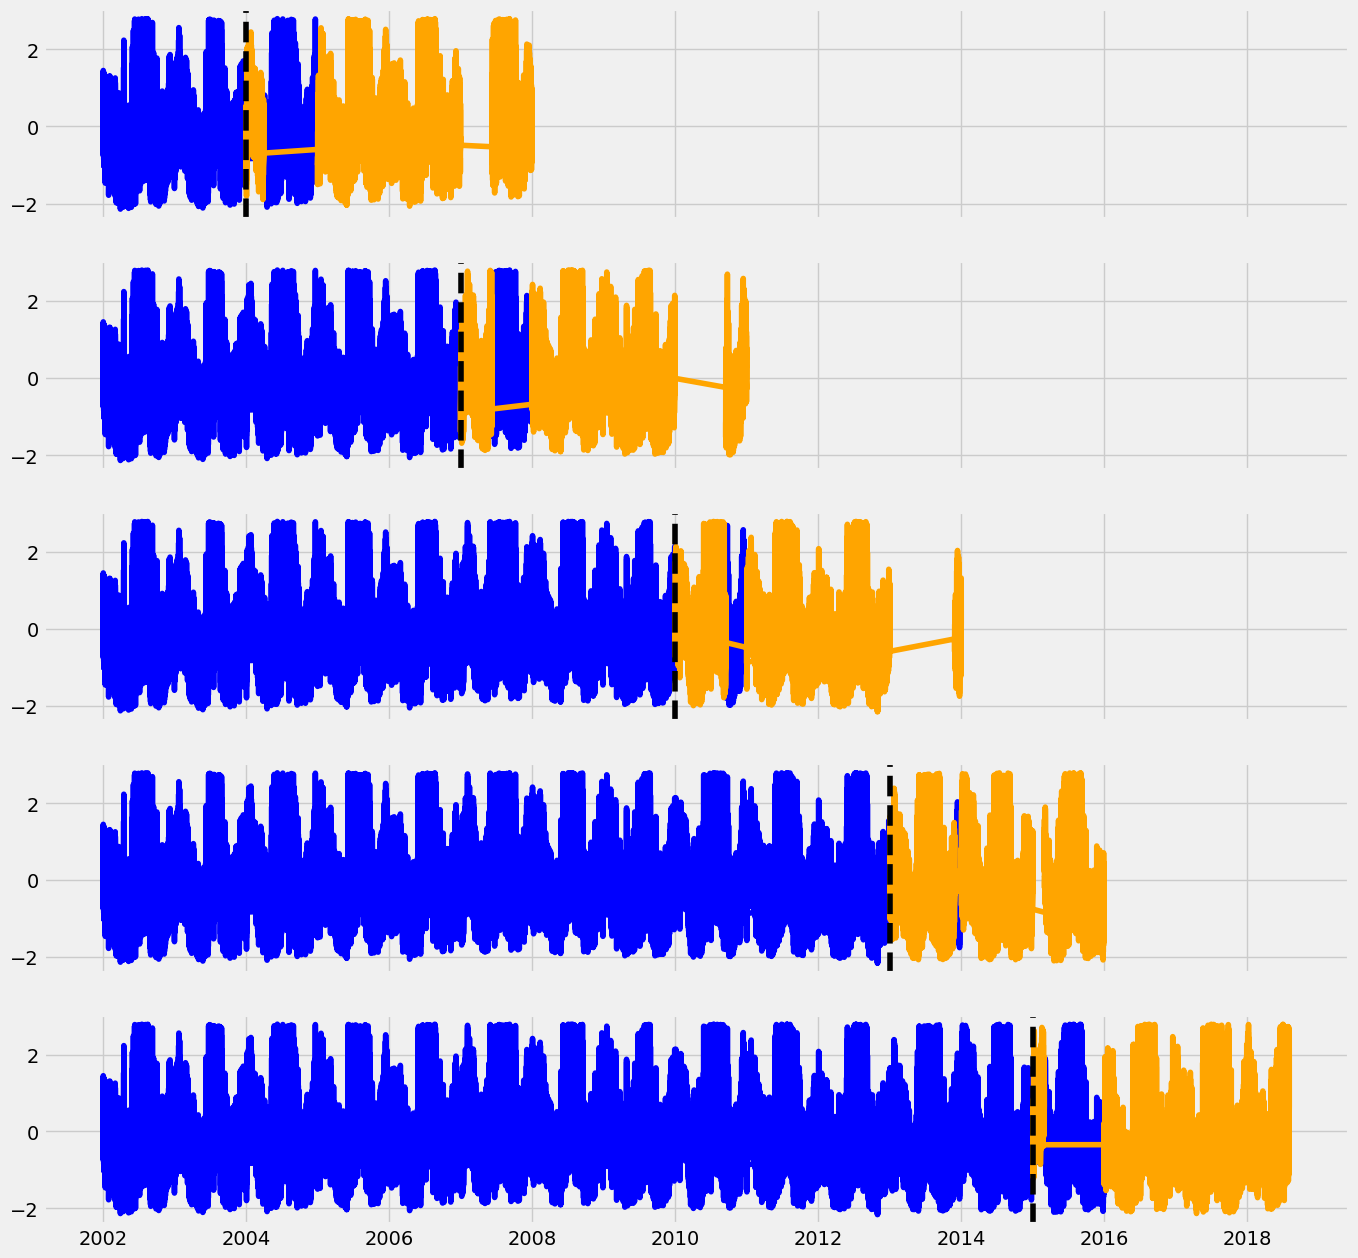

In [43]:
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[['PJME_MW']]), index=df.index, columns=['PJME_MW'])

# Preparing for time series cross-validation
tss = TimeSeriesSplit(n_splits=5)

# Plotting
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df_scaled):
    train = df_scaled.iloc[train_idx]
    test = df_scaled.iloc[val_idx]

    # Plotting training set with blue color
    axs[fold].plot(train.index, train['PJME_MW'], label='Training Set', color='blue')

    # Plotting test set with orange color
    axs[fold].plot(test.index, test['PJME_MW'], label='Test Set', color='orange')

    # Adding a vertical line for the split date
    axs[fold].axvline(test.index.min(), color='black', ls='--')

    fold += 1

plt.show()


## Building an LSTM MODEL

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout

In [ ]:
# Cross-validation for LSTM
for fold, (train_idx, val_idx) in enumerate(tss.split(df_scaled)):
    print(f"Processing LSTM model for fold {fold}...")
    train, test = df_scaled.iloc[train_idx], df_scaled.iloc[val_idx]


In [ ]:
# Reshape data for LSTM: [samples, time steps, features]
X_train = train.values.reshape((train.shape[0], 1, train.shape[1]))
X_test = test.values.reshape((test.shape[0], 1, test.shape[1]))
y_train = train['PJME_MW'].values
y_test = test['PJME_MW'].values


In [ ]:
 # Define LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(1, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


In [ ]:
# Fit model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)


In [62]:
# Make predictions
y_pred = model.predict(X_test, verbose=0)

In [63]:
# Evaluate the model
lstm_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Fold {fold} LSTM model RMSE: {lstm_rmse}")


Fold 4 LSTM model RMSE: 0.0010990100698753155


## Saving the Model

In [67]:
model_save_path = 'lstm_model.h5'
model.save(model_save_path)


## Creating a Flask Application

In [68]:
from flask import Flask, request, jsonify
from tensorflow.keras.models import load_model


In [69]:
app = Flask(__name__)

# Load the saved model
model = load_model('lstm_model.h5')

In [ ]:
@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json(force=True)
    # data is a dictionary with the key 'input_data'
    input_data = np.array(data['input_data']).reshape((1, 1, 1))  # Reshape as required by the LSTM model

    prediction = model.predict(input_data)
    return jsonify({'prediction': prediction.tolist()})

if __name__ == '__main__':
    app.run(debug=True)


## Bonus Questions 

## 1) How does energy consumption vary between weekdays and weekends?

In [75]:
df['weekday'] = df.index.weekday
weekend_consumption = df[df['weekday'] >= 5]['PJME_MW'].mean()
weekday_consumption = df[df['weekday'] < 5]['PJME_MW'].mean()

print("Weekday Average Consumption:", weekday_consumption)
print("Weekend Average Consumption:", weekend_consumption)


Weekday Average Consumption: 32426.32353525323
Weekend Average Consumption: 29638.334611743572


## 2) Is there any seasonality in energy consumption?

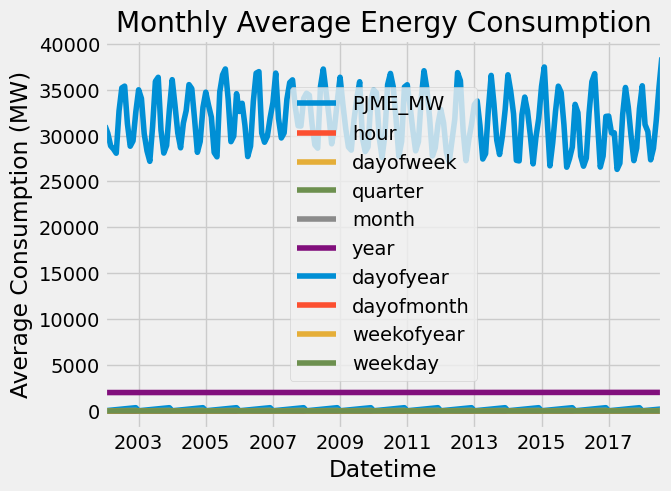

In [76]:
monthly_avg = df.resample('M').mean()
monthly_avg.plot()

plt.title("Monthly Average Energy Consumption")
plt.ylabel("Average Consumption (MW)")
plt.show()


## 3) What are the peak energy consumption hours?


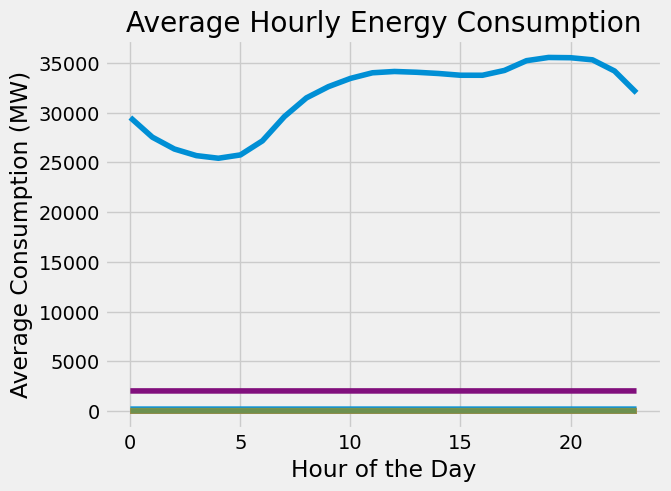

In [77]:
avg_hourly_consumption = df.groupby(df.index.hour).mean()

plt.plot(avg_hourly_consumption)
plt.title("Average Hourly Energy Consumption")
plt.xlabel("Hour of the Day")
plt.ylabel("Average Consumption (MW)")
plt.show()


## 4) Are there any trends in energy consumption over the years?



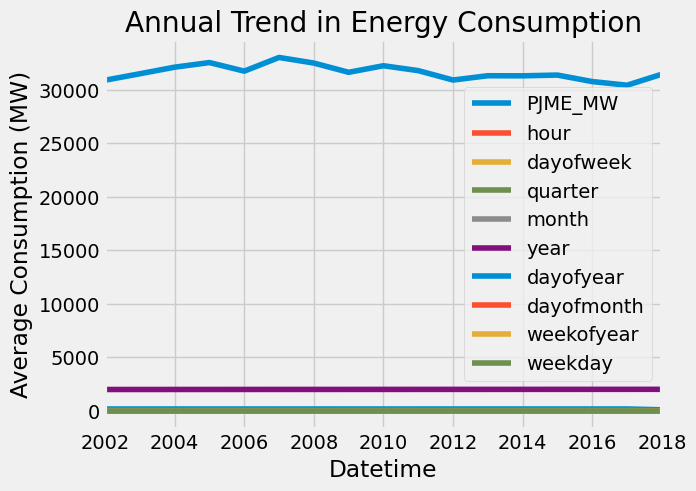

In [78]:
annual_trend = df.resample('Y').mean()
annual_trend.plot()

plt.title("Annual Trend in Energy Consumption")
plt.ylabel("Average Consumption (MW)")
plt.show()
